In [137]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [138]:
# torch

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

import os
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from PIL import Image


import torch.nn as nn
import torch.nn.functional as F

In [139]:
# warning off
import warnings
warnings.simplefilter('ignore')

# default font
plt.rcParams['font.size'] = 14

# default graph size
plt.rcParams['figure.figsize'] = (4,4)

# default graph grid
# plt.rcParams['axes.grid'] = True

# numpy precision
np.set_printoptions(suppress=True, precision=5)

# GPU

In [21]:
# device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preparation

In [63]:
data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'

# data formatting (only one time run at the beginning)
def format_val():
    val_dir = data_dir_path + '/val'
    print("Formatting: {}".format(val_dir))
    val_annotations = "{}/val_annotations.txt".format(val_dir)
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            line = line.strip().split()
            assert(len(line) == 6)
            wnind = line[1]
            img_name = line[0]
            boxes = '\t'.join(line[2:])
            if wnind not in val_dict:
                val_dict[wnind] = []
            entries = val_dict[wnind]
            entries.append((img_name, boxes))
    assert(len(val_dict) == 200)
    for wnind, entries in val_dict.items():
        val_wnind_dir = "{}/{}".format(val_dir, wnind)
        val_images_dir = "{}/images".format(val_dir)
        val_wnind_images_dir = "{}/images".format(val_wnind_dir)
        os.mkdir(val_wnind_dir)
        os.mkdir(val_wnind_images_dir)
        wnind_boxes = "{}/{}_boxes.txt".format(val_wnind_dir, wnind)
        f = open(wnind_boxes, "w")
        for img_name, box in entries:
            source = "{}/{}".format(val_images_dir, img_name)
            dst = "{}/{}".format(val_wnind_images_dir, img_name)
            os.system("cp {} {}".format(source, dst))
            f.write(img_name+'\\'+box+'\\'+'n')
        f.close()
    # os.system("rm -rf %s" % val_images_dir)
    #print("Cleaning up: %s" % val_images_dir)
    print("Formatting val done")
    
    
# create dataset object
train_dataset = ImageFolder(data_dir_path + '/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir_path + '/test', transform=ToTensor())

# Texting label (only one time run at the beginning)
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

print(len(d))

aa = train_dataset.classes
for i in range(len(aa)):
    train_dataset.classes[i] = d[aa[i]]

82115


In [73]:
random_seed = 4
torch.manual_seed(random_seed);

val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(90000, 10000)

Label:  jinrikisha, ricksha, rickshaw (111)


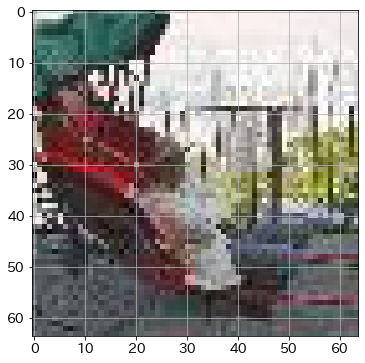

In [54]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*train_dataset[55555])

# Test of nn.Conv2d nn.Maxpool2d

In [47]:
conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2) # out: [16, 64, 64
relu = nn.ReLU(inplace=True) # out: 16, 64, 64
maxpool = nn.MaxPool2d((2,2)) # output: 16, 32, 32

conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # output: 16, 16, 16

In [86]:
# 関数定義
features = nn.Sequential(
    conv1, # out: 16, 64, 64
    relu, # out: 16, 64, 64
    conv2, # out: 16, 64, 64
    relu, # out: 16, 64, 64
    maxpool, # out: 16, 32, 32
)

# 関数定義
flatten = nn.Flatten()


In [87]:
# 動作テスト
outputs = features(inputs)

# 結果確認
print(outputs.shape)

# 動作テスト
outputs2 = flatten(outputs)

# 結果確認
print(outputs.shape)
print(outputs2.shape)


torch.Size([100, 16, 16, 16])
torch.Size([100, 16, 16, 16])
torch.Size([100, 4096])


# def of common functions

## eval_loss loss calc

In [88]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

## fit learning

In [114]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

## eval_history log analysis of learning

In [133]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'Initial: loss: {history[0,3]:.5f} accuracy: {history[0,4]:.5f}') 
    print(f'Final: loss: {history[-1,3]:.5f} accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()

##  show_images_labels show image and label

In [155]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 10)

    if net is not None:
      # デバイスの割り当て
        inputs = images.to(device)
        labels = labels.to(device)

      # 予測計算
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(, 2, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
            predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'b'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
            ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

SyntaxError: invalid syntax (4054164993.py, line 23)

In [148]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## data prep

In [118]:
image1, label1 = train_dataset[0]
image2, label2 = train_dataset[1330]

print(image1.shape)
print(image2.shape)
print(label1)
print(label2)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
0
2


In [119]:
# DataLoader

# size of batch
batch_size = 100

# DataLoarder of Training data
train_loader2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# DataLoarder of Test data
test_loader2 = DataLoader(val_ds,  batch_size=batch_size, shuffle=False) 

In [120]:
# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images2.shape)



torch.Size([100, 3, 64, 64])


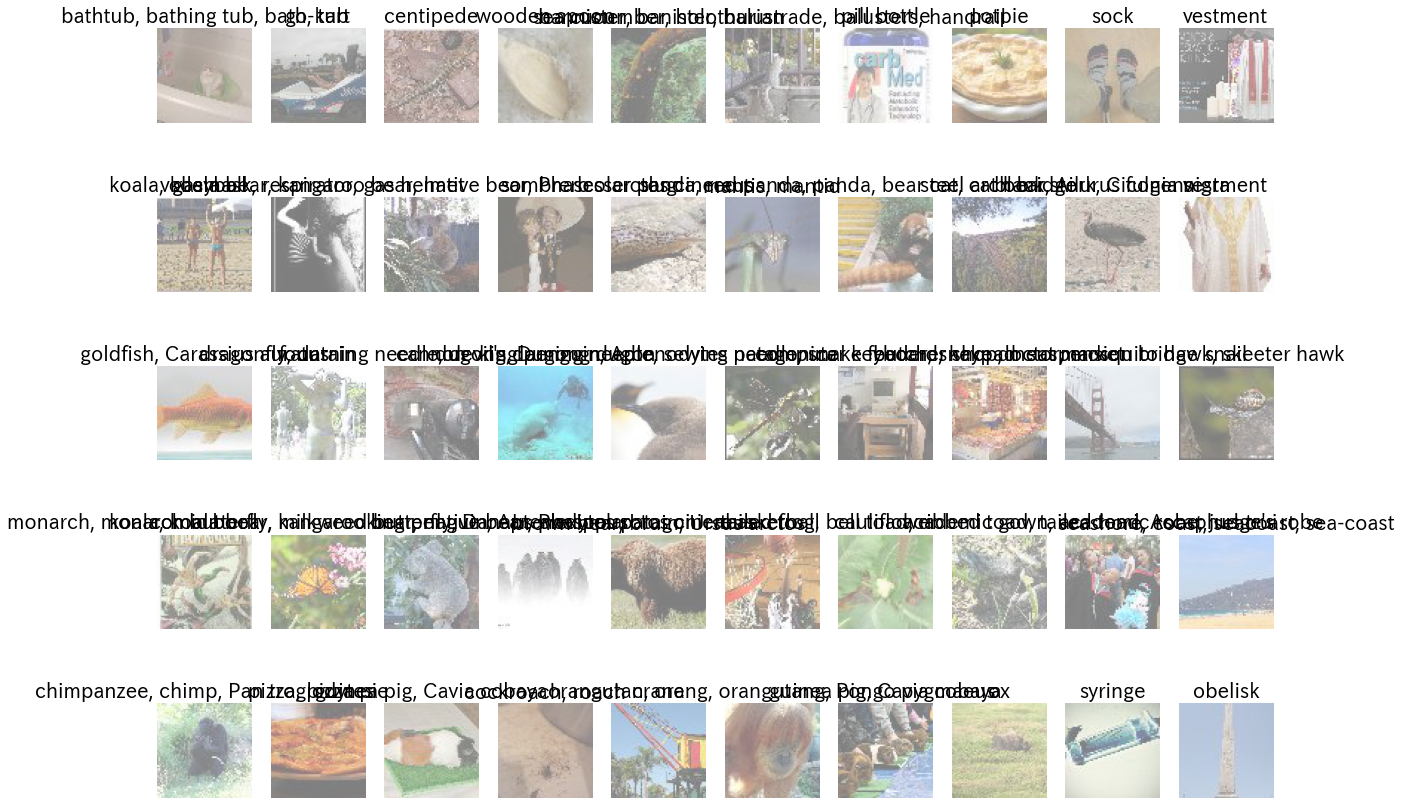

In [121]:
# 正解ラベル定義
classes = train_dataset.classes

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

# Def Model

### Parameters

In [135]:
# output degree: 出力次元数
# number of classes: 分類先クラス数
n_output = len(classes)

# number of nodes of hidden layer 隠れ層のノード数
n_hidden = 1024 

print(f'n_hidden: {n_hidden} n_output: {n_output}')



n_hidden: 1024 n_output: 200


In [123]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2) 
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(16384, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,# out: 16, 64, 64
            self.relu,# out: 16, 64, 64
            self.conv2,# out: 16, 64, 64
            self.relu,# out: 16, 64, 64
            self.maxpool)# out: 16, 32, 32

        self.classifier = nn.Sequential(
           self.l1,
           self.relu,
           self.l2)

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [124]:
conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2) # out: [16, 64, 64
relu = nn.ReLU(inplace=True) # out: 16, 64, 64
maxpool = nn.MaxPool2d((2,2)) # output: 16, 32, 32

conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)


# def function: 関数定義
features = nn.Sequential(
    conv1, # out: 16, 64, 64
    relu, # out: 16, 64, 64
    conv2, # out: 16, 64, 64
    relu, # out: 16, 64, 64
    maxpool, # out: 16, 32, 32
)


### Create model instance

In [125]:
# create model instanceモデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# loss function: cross entropy 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# learning ratio: 学習率
lr = 0.01

# optimizer: gradient 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)



In [126]:
# summary of model: モデルの概要表示

print(net)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=16384, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=200, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=200, bias=True)
  )
)


In [127]:
# summary of model:モデルのサマリー表示

summary(net,(100,3,64,64),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 16, 32, 32]         3,536
├─Conv2d: 1-2                            [100, 16, 64, 64]         1,216
├─ReLU: 1-3                              [100, 16, 64, 64]         --
├─Conv2d: 1-4                            [100, 16, 64, 64]         2,320
├─ReLU: 1-5                              [100, 16, 64, 64]         --
├─MaxPool2d: 1-6                         [100, 16, 32, 32]         --
├─Flatten: 1-7                           [100, 16384]              --
├─Sequential: 1-8                        [100, 200]                16,983,240
├─Linear: 1-9                            [100, 1024]               16,778,240
├─ReLU: 1-10                             [100, 1024]               --
├─Linear: 1-11                           [100, 200]                205,000
Total params: 16,986,776
Trainable params: 16,986,776
N

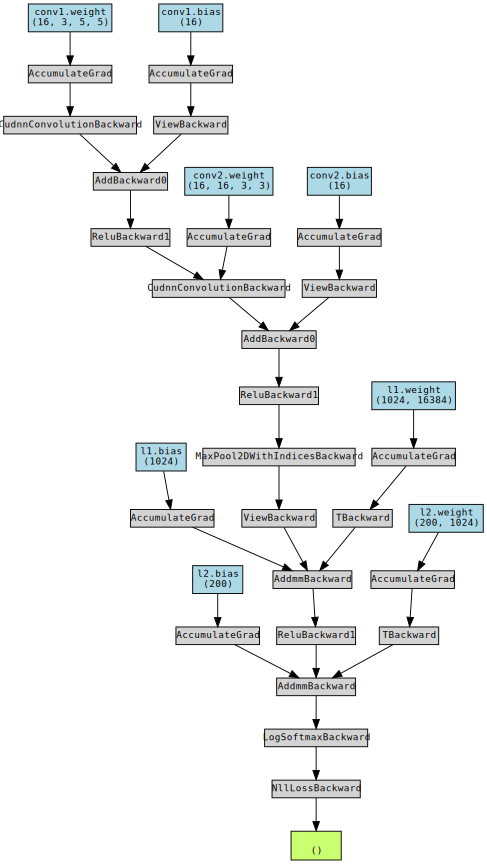

In [128]:
# calc loss: 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# visualize calc loss: 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)



In [130]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)



  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.05279 acc: 0.00982 val_loss: 0.05194, val_acc: 0.01880


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.05000 acc: 0.03052 val_loss: 0.04894, val_acc: 0.04320


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.04813 acc: 0.05203 val_loss: 0.04758, val_acc: 0.05770


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.04652 acc: 0.06868 val_loss: 0.04639, val_acc: 0.07220


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.04498 acc: 0.08738 val_loss: 0.04560, val_acc: 0.08170


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.04359 acc: 0.10577 val_loss: 0.04444, val_acc: 0.09150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.04233 acc: 0.12180 val_loss: 0.04353, val_acc: 0.10810


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.04112 acc: 0.13898 val_loss: 0.04287, val_acc: 0.11650


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.03981 acc: 0.15643 val_loss: 0.04257, val_acc: 0.12690


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.03847 acc: 0.17842 val_loss: 0.04189, val_acc: 0.13320


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.03710 acc: 0.19822 val_loss: 0.04157, val_acc: 0.14110


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.03577 acc: 0.21851 val_loss: 0.04147, val_acc: 0.14550


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.03435 acc: 0.24206 val_loss: 0.04135, val_acc: 0.15000


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.03281 acc: 0.26840 val_loss: 0.04143, val_acc: 0.15180


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.03114 acc: 0.29612 val_loss: 0.04193, val_acc: 0.14910


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.02924 acc: 0.32947 val_loss: 0.04272, val_acc: 0.14900


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.02716 acc: 0.36694 val_loss: 0.04416, val_acc: 0.14470


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.02479 acc: 0.41442 val_loss: 0.04528, val_acc: 0.15010


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.02220 acc: 0.46818 val_loss: 0.04664, val_acc: 0.14200


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01947 acc: 0.52338 val_loss: 0.04924, val_acc: 0.13580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01651 acc: 0.59052 val_loss: 0.05203, val_acc: 0.13280


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01363 acc: 0.65604 val_loss: 0.05639, val_acc: 0.12210


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01089 acc: 0.72150 val_loss: 0.05922, val_acc: 0.13050


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00838 acc: 0.78501 val_loss: 0.06421, val_acc: 0.12190


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00636 acc: 0.83621 val_loss: 0.06861, val_acc: 0.12210


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00473 acc: 0.87754 val_loss: 0.07246, val_acc: 0.12290


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00348 acc: 0.91074 val_loss: 0.07760, val_acc: 0.12110


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00243 acc: 0.94066 val_loss: 0.08024, val_acc: 0.12340


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00163 acc: 0.96240 val_loss: 0.08403, val_acc: 0.12420


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00112 acc: 0.97570 val_loss: 0.08767, val_acc: 0.12150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00080 acc: 0.98327 val_loss: 0.08986, val_acc: 0.12560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00052 acc: 0.99019 val_loss: 0.09178, val_acc: 0.12870


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00041 acc: 0.99317 val_loss: 0.09296, val_acc: 0.12340


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00030 acc: 0.99509 val_loss: 0.09622, val_acc: 0.12920


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00024 acc: 0.99633 val_loss: 0.09721, val_acc: 0.12940


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00015 acc: 0.99784 val_loss: 0.09915, val_acc: 0.12900


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00013 acc: 0.99838 val_loss: 0.09987, val_acc: 0.13100


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00012 acc: 0.99851 val_loss: 0.09980, val_acc: 0.13180


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00009 acc: 0.99913 val_loss: 0.10110, val_acc: 0.12950


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00009 acc: 0.99918 val_loss: 0.10160, val_acc: 0.13090


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00008 acc: 0.99932 val_loss: 0.10338, val_acc: 0.13110


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00008 acc: 0.99939 val_loss: 0.10255, val_acc: 0.13320


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00007 acc: 0.99939 val_loss: 0.10321, val_acc: 0.13150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00007 acc: 0.99929 val_loss: 0.10340, val_acc: 0.13350


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00006 acc: 0.99950 val_loss: 0.10411, val_acc: 0.13390


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00006 acc: 0.99960 val_loss: 0.10500, val_acc: 0.13300


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00005 acc: 0.99967 val_loss: 0.10512, val_acc: 0.13130


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00006 acc: 0.99962 val_loss: 0.10529, val_acc: 0.13180


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00006 acc: 0.99961 val_loss: 0.10505, val_acc: 0.13280


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00006 acc: 0.99961 val_loss: 0.10560, val_acc: 0.13100


Initial: loss: 0.05194 accuracy: 0.01880
Final: loss: 0.10560 accuracy: 0.13100


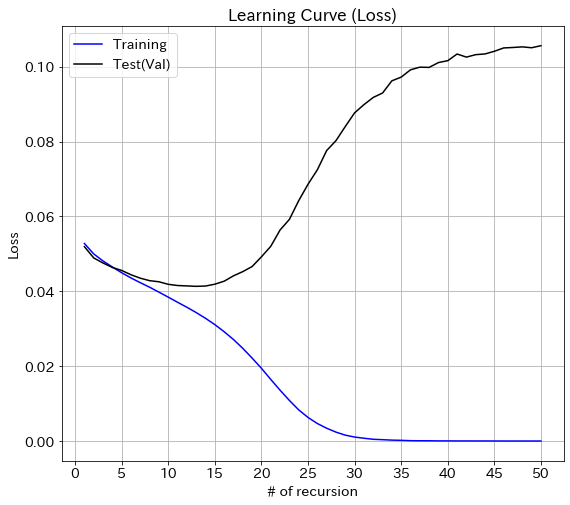

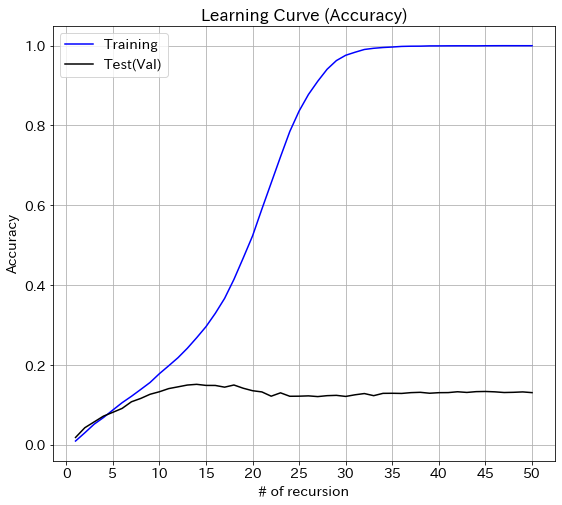

In [140]:
# 評価

evaluate_history(history2)


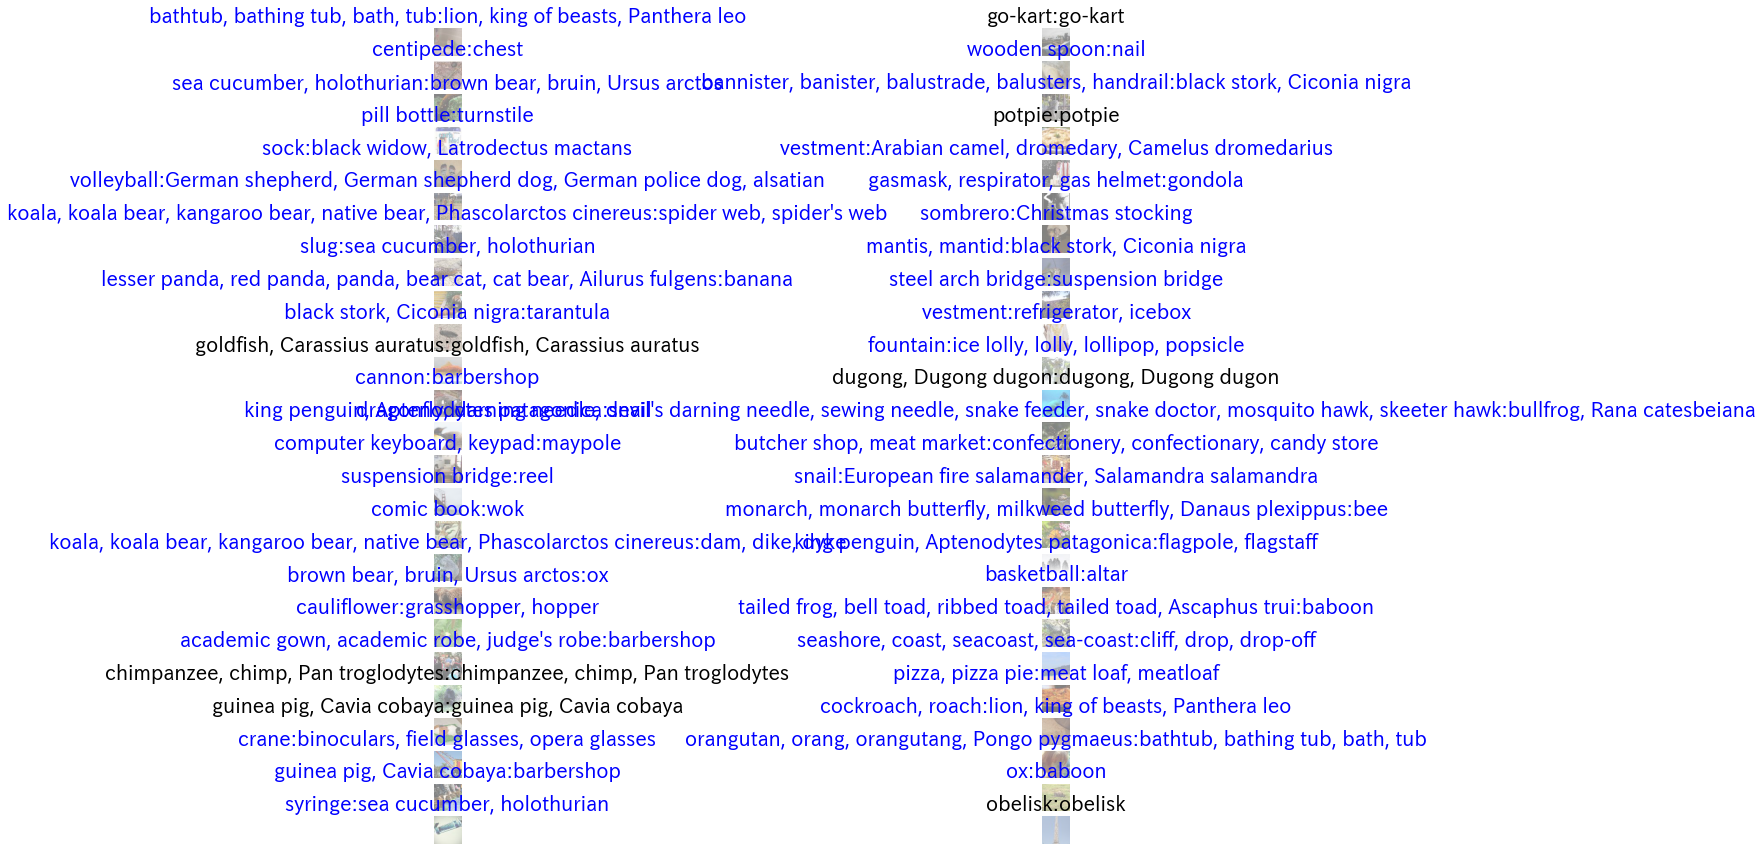

In [154]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)

